In [17]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
# 2. Load Dataset
df = pd.read_csv(r"C:\Users\kunda\OneDrive\Desktop\green_Ai_Project\pollution_2000_2023.csv", low_memory=False)

In [20]:
# 3. Data Preprocessing
df = df.drop(columns=["Unnamed: 0", "Address"], errors="ignore")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"])
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df = df.sort_values("date")

In [29]:
# Focus on one city for simplicity
city_df = df[df["city"] == "Los Angeles"].copy()

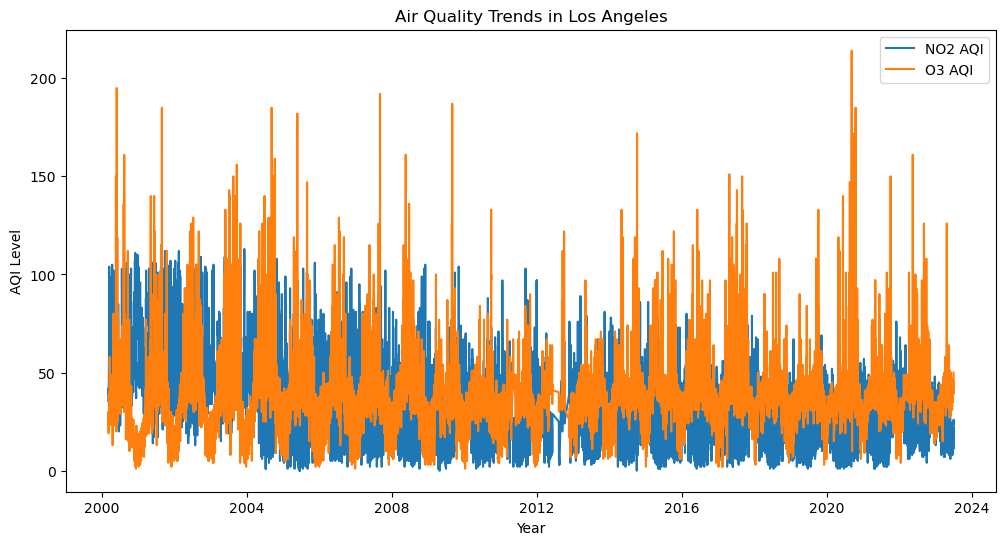

In [36]:
# 4. Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,6))
plt.plot(city_df["date"], city_df["no2_aqi"], label="NO2 AQI")
plt.plot(city_df["date"], city_df["o3_aqi"], label="O3 AQI")
plt.legend()
plt.title("Air Quality Trends in Los Angeles")
plt.xlabel("Year")
plt.ylabel("AQI Level")
plt.show()

In [31]:
# 5. Feature Engineering
# Predict NO2 AQI (example target)
city_df["no2_aqi_lag1"] = city_df["no2_aqi"].shift(1)
city_df["no2_aqi_ma3"] = city_df["no2_aqi"].rolling(window=3).mean()
city_df = city_df.dropna()
features = ["no2_aqi_lag1", "no2_aqi_ma3", "o3_mean", "so2_mean", "co_mean"]
target = "no2_aqi"
X = city_df[features]
y = city_df[target]


In [32]:
# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [33]:
# 7. Train ML Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
# 8. Model Evaluation
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 3.605770625928027
R² Score: 0.8991511485115696


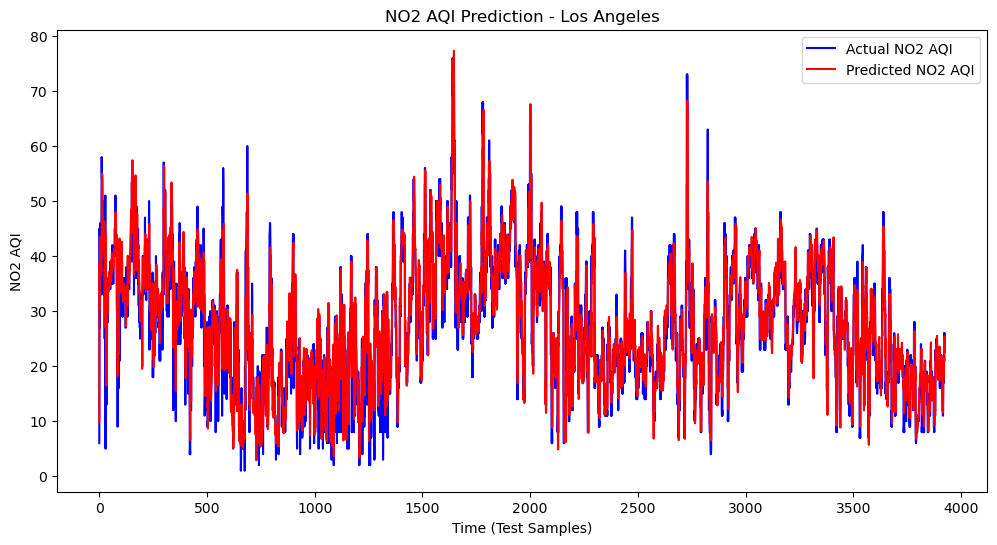

In [35]:
# 9. Visualization of Predictions
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual NO2 AQI", color="blue")
plt.plot(y_pred, label="Predicted NO2 AQI", color="red")
plt.legend()
plt.title("NO2 AQI Prediction - Los Angeles")
plt.xlabel("Time (Test Samples)")
plt.ylabel("NO2 AQI")
plt.show()

In [4]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Load dataset ===
csv_path = r"C:\Users\kunda\OneDrive\Documents\green_Ai_internship\pollution_2000_2023.csv"
df = pd.read_csv(csv_path)

print("=== DATA SAMPLE ===")
print(df.head())

# ---- Pick target (last column for simplicity) ----
target = df.columns[-1]
df = df.dropna(subset=[target])

# ---- Optional: sample for speed during development ----
if len(df) > 5000:   # keep max 5000 rows while testing
    df = df.sample(5000, random_state=42)

X = df.drop(columns=[target])
y = df[target]

# ---- Feature types ----
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Drop very high cardinality categorical columns (>50 unique values)
cat_cols = [c for c in cat_cols if X[c].nunique() < 50]

print(f"Target = {target}")
print(f"Numeric features = {len(num_cols)}, Categorical features = {len(cat_cols)}")

# ---- Transformers ----
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True, max_categories=20))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# ---- Candidate models (reduced for speed) ----
models = {
    "Ridge": Ridge(alpha=1.0, random_state=42, max_iter=500),
    "HistGradientBoosting": HistGradientBoostingRegressor(
        max_iter=100, max_depth=6, random_state=42
    )
}

# ---- Train/validation split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []
trained = {}

# ---- Train & evaluate ----
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    print(f"\nTraining {name} ...")
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    r2 = r2_score(y_test, preds)
    results.append((name, mae, rmse, r2))
    trained[name] = pipe
    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

# ---- Pick best model by RMSE ----
results.sort(key=lambda x: x[2])
best_name, best_mae, best_rmse, best_r2 = results[0]
best_pipe = trained[best_name]

print("\n=== BEST MODEL ===")
print(f"{best_name} | MAE={best_mae:.4f}, RMSE={best_rmse:.4f}, R2={best_r2:.4f}")

# ---- Save artifacts to Desktop/artifacts ----
# Change the path to a directory instead of a CSV file
outdir = Path(r"C:\Users\kunda\OneDrive\Documents\green_Ai_internship\artifacts")
outdir.mkdir(exist_ok=True)

dump(best_pipe, outdir / "best_air_model.joblib")
with open(outdir / "feature_schema.json", "w") as f:
    json.dump({
        "numeric_features": num_cols,
        "categorical_features": cat_cols,
        "target": target,
        "best_model": best_name
    }, f, indent=2)

pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"]).to_csv(outdir / "metrics.csv", index=False)

print(f"\nArtifacts saved to {outdir.resolve()}")

=== DATA SAMPLE ===
   Unnamed: 0        Date                                  Address    State  \
0           0  2000-01-01  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
1           1  2000-01-02  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
2           2  2000-01-03  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
3           3  2000-01-04  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
4           4  2000-01-05  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   

     County     City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI  \
0  Maricopa  Phoenix  0.019765             0.040               10      37   
1  Maricopa  Phoenix  0.015882             0.032               10      30   
2  Maricopa  Phoenix  0.009353             0.016                9      15   
3  Maricopa  Phoenix  0.015882             0.033                9      31   
4  Maricopa  Phoenix  0.007353             0.012                9      11   

   ...  CO 1st Max Hour  CO AQI  SO2 Mean 